In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/sample_submission.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/train.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/test.csv


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#!pip install sentence_transformers

In [4]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import (
    LogisticRegression, RidgeClassifier,
    PassiveAggressiveClassifier, Perceptron
)
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

2025-08-20 15:09:48.893380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755702589.166141      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755702589.245058      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
df = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/train.csv')
test_df = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/test.csv')

# Identify data types of different columns

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26500 entries, 0 to 26499
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             26500 non-null  int64  
 1   store_name     26500 non-null  object 
 2   category       26500 non-null  object 
 3   store_address  26500 non-null  object 
 4   latitude       25976 non-null  float64
 5   longitude      25976 non-null  float64
 6   rating_count   26500 non-null  object 
 7   review_time    26500 non-null  object 
 8   review         26500 non-null  object 
 9   rating         26500 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 2.0+ MB


Drop Columns

In [7]:
for i in (df, test_df):
  i.drop(columns=['id'], inplace=True)

In [8]:
for i in (df, test_df):
  i.drop(columns=['store_name', 'category'], inplace=True)

Converting review_type to numeric

In [9]:
def get_hours_ago(time: str) -> int:
  components = time.split(' ')
  num_value = components[0]
  if num_value == 'a':
    num_value = 1
  else:
    num_value = int(num_value)

  if components[1].startswith('hour'):
    multiplier = 1
  elif components[1].startswith('day'):
    multiplier = 24
  elif components[1].startswith('week'):
    multiplier = 24 * 7
  elif components[1].startswith('month'):
    multiplier = 24 * 30
  elif components[1].startswith('year'):
    multiplier = 24 * 365

  return num_value * multiplier

for i in (df, test_df):
  i['review_time'] = i['review_time'].apply(get_hours_ago)
  i.rename(columns={'review_time': 'hours_ago'}, inplace=True)

Removing Space

In [10]:
df.rename(columns={'latitude ': 'latitude'}, inplace=True)

Removing comma

In [11]:
for i in (df, test_df):
  i['rating_count'] = i['rating_count'].str.replace(',', '').astype(int)

Dropping unimportant

In [12]:
for i in (df, test_df):
  i.drop(columns=['store_address'], inplace=True)

# Present descriptive statistics of numerical columns

In [13]:
df.describe()

,latitude,longitude,rating_count,hours_ago,rating
count,25976.000000,25976.000000,26500.000000,26500.000000,26500.000000
mean,34.427152,-90.659226,2589.235585,24819.722906,3.130642
std,5.336112,16.588603,2528.202311,16079.226660,1.615425
min,25.790295,-121.995421,263.000000,6.000000,1.000000
25%,28.655350,-97.792874,1406.000000,8760.000000,1.000000
50%,33.931261,-81.471414,1795.000000,26280.000000,3.000000
75%,40.727401,-75.399919,2810.000000,35040.000000,5.000000
max,44.981410,-73.459820,19682.000000,105120.000000,5.000000


# Identify and Handle Missing Values

In [14]:
df.isna().sum()

latitude        524
longitude       524
rating_count      0
hours_ago         0
review            0
rating            0
dtype: int64

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

imputer=ColumnTransformer([('most_frequent',SimpleImputer(missing_values=np.nan, strategy='most_frequent'),['latitude','longitude'])],remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')
df=imputer.fit_transform(df)
test_df=imputer.fit_transform(test_df)

In [16]:
df.isna().sum()

latitude        0
longitude       0
rating_count    0
hours_ago       0
review          0
rating          0
dtype: int64

In [17]:
test_df.isna().sum()

latitude        0
longitude       0
rating_count    0
hours_ago       0
review          0
dtype: int64

# Identify and handle duplicates

In [18]:
init_samples = df.shape[0]
df.drop_duplicates(inplace=True, ignore_index=True)
print(f"Duplicates removed: {init_samples - df.shape[0]}")

Duplicates removed: 3316


# Identify and handle outliers

In [19]:
outliers_present = {'Train': {}, 'Test': {}}

IQR_multiplier = 2
for col in ['latitude', 'longitude', 'rating_count', 'hours_ago']:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - IQR_multiplier * IQR
  upper_bound = Q3 + IQR_multiplier * IQR

  for i in (df, test_df):
    outliers = i[(i[col] < lower_bound) | (i[col] > upper_bound)].shape[0]
    if i.shape[0] > 20000:
      outliers_present['Train'][col] = outliers
    else:
      outliers_present['Test'][col] = outliers
    i[col].clip(lower=lower_bound, upper=upper_bound, inplace=True)

for i in outliers_present:
  print(f"Outliers Removed in {i} Data:")
  for col in outliers_present[i]:
    print(f"    {col}: {outliers_present[i][col]}")
  print()

Outliers Removed in Train Data:
    latitude: 0
    longitude: 0
    rating_count: 395
    hours_ago: 8

Outliers Removed in Test Data:
    latitude: 0
    longitude: 0
    rating_count: 95
    hours_ago: 6



# Visualizations and Insights

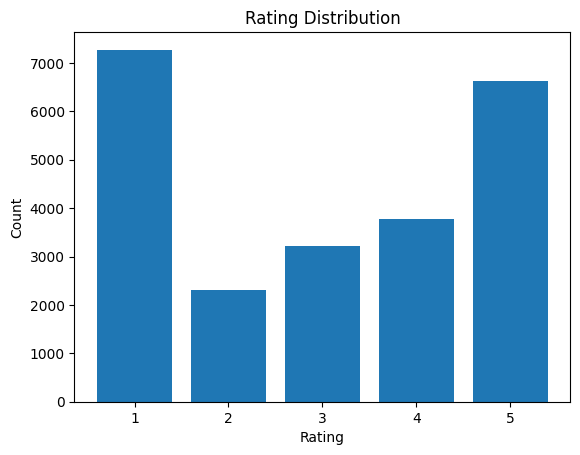

In [20]:
plot_df = df['rating'].value_counts()

plt.bar(plot_df.index, plot_df)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

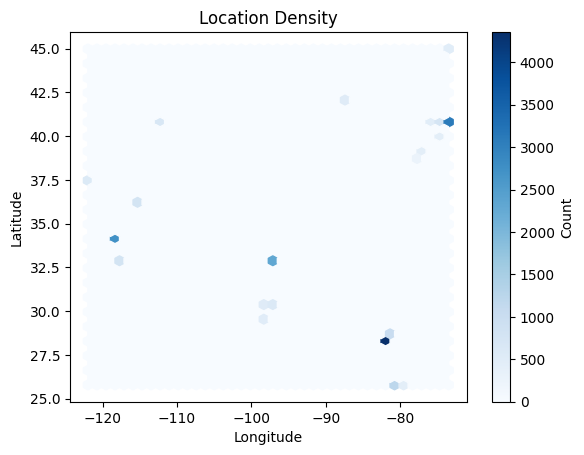

In [21]:
plt.hexbin(df['longitude'], df['latitude'], gridsize=40, cmap='Blues')
plt.colorbar(label='Count')
plt.title("Location Density")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

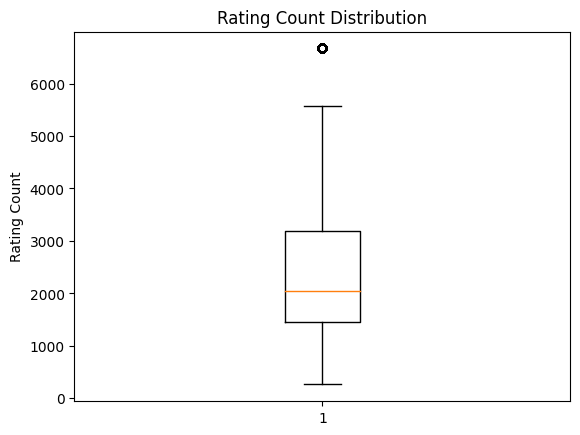

In [22]:
plt.boxplot(df['rating_count'])
plt.title("Rating Count Distribution")
plt.ylabel("Rating Count")
plt.show()

# Scale Numerical features and Encode Categorical features

In [23]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [24]:
for i in ('df', 'test_df'):
  temp_df = globals()[i]

  review_embeddings = model.encode(
    temp_df['review'],
    show_progress_bar=True,
    normalize_embeddings=True,
    convert_to_numpy=True,
  )

  temp_df.drop(columns=['review'], inplace=True)
  review_embeddings_df = pd.DataFrame(
      review_embeddings,
      columns=[f"review_{i}" for i in range(0, review_embeddings.shape[1])]
  )
  temp_df = pd.concat([temp_df, review_embeddings_df], axis=1)

  globals()[i] = temp_df

Batches:   0%|          | 0/725 [00:00<?, ?it/s]

Batches:   0%|          | 0/219 [00:00<?, ?it/s]

In [25]:
del temp_df, review_embeddings, review_embeddings_df

In [26]:
train_x, valid_x, train_y, valid_y = train_test_split(
    df.drop(columns=['rating']),
    df['rating'],
    test_size=0.2,
    random_state=42,
)

In [27]:
num_cols = ['latitude', 'longitude', 'rating_count', 'hours_ago']
pass_cols = train_x.columns[4:].tolist()

In [28]:
transformer = ColumnTransformer(transformers=[
    ('ss', StandardScaler(), num_cols),
    ('pass', 'passthrough', pass_cols)
])
transformer.fit(train_x, train_y)

ColumnTransformer(transformers=[('ss', StandardScaler(),
                                 ['latitude', 'longitude', 'rating_count',
                                  'hours_ago']),
                                ('pass', 'passthrough',
                                 ['review_0', 'review_1', 'review_2',
                                  'review_3', 'review_4', 'review_5',
                                  'review_6', 'review_7', 'review_8',
                                  'review_9', 'review_10', 'review_11',
                                  'review_12', 'review_13', 'review_14',
                                  'review_15', 'review_16', 'review_17',
                                  'review_18', 'review_19', 'review_20',
                                  'review_21', 'review_22', 'review_23',
                                  'review_24', 'review_25', 'review_26',
                                  'review_27', 'review_28', 'review_29', ...])])

In [29]:
for var in ('train_x', 'valid_x'):
    i = globals()[var]

    transformed = transformer.transform(i)
    feature_names = transformer.get_feature_names_out()
    index = i.index
    i = pd.DataFrame(transformed, columns=feature_names, index=index)

    globals()[var] = i

# Model Building (at least 7)

In [30]:
results = {}
models = {
  "Logistic Regression": LogisticRegression(random_state=42, n_jobs=-1, multi_class='multinomial'),
  "Ridge Classifier": RidgeClassifier(random_state=42),
  "PassiveAggressiveClassifier": PassiveAggressiveClassifier(random_state=42),
  "Perceptron": Perceptron(random_state=42, n_jobs=-1),
  "Extra Trees": ExtraTreesClassifier(random_state=42, n_jobs=-1),
  "XGBoost": XGBClassifier(random_state=42, n_jobs=-1),
  "KNN": KNeighborsClassifier(n_jobs=-1)
}

In [31]:
for model_name in models:
  init_time = time.time()

  try:
    print(f"---Training {model_name}---")
    if model_name == "XGBoost":
      models[model_name].fit(train_x, train_y - 1)
    else:
      models[model_name].fit(train_x, train_y)

    if model_name == "XGBoost":
      valid_pred = models[model_name].predict(valid_x) + 1
    else:
      valid_pred = models[model_name].predict(valid_x)

    f1 = f1_score(valid_y, valid_pred, average='macro')
    accuracy = accuracy_score(valid_y, valid_pred)
    precision = precision_score(valid_y, valid_pred, average='macro')
    recall = recall_score(valid_y, valid_pred, average='macro')
    time_taken = time.time() - init_time

    results[model_name] = {
      "F1": round(f1, 4),
      "Accuracy": round(accuracy, 4),
      "Precision": round(precision, 4),
      "Recall": round(recall, 4),
      "Time": round(time_taken, 2),
    }
    print('\n'.join([f'{metric}: {value}' for metric, value in results[model_name].items()]))
  except Exception as e:
    print(f"{model_name} training failed with the following error:")
    print(e)
    continue
  finally:
    print('\n')

---Training Logistic Regression---


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1: 0.4652
Accuracy: 0.6028
Precision: 0.5115
Recall: 0.4709
Time: 3.94


---Training Ridge Classifier---
F1: 0.4342
Accuracy: 0.6038
Precision: 0.5357
Recall: 0.4513
Time: 0.36


---Training PassiveAggressiveClassifier---
F1: 0.3713
Accuracy: 0.5027
Precision: 0.4047
Recall: 0.3801
Time: 1.38


---Training Perceptron---
F1: 0.4268
Accuracy: 0.5415
Precision: 0.4362
Recall: 0.4296
Time: 0.49


---Training Extra Trees---
F1: 0.5329
Accuracy: 0.6465
Precision: 0.7025
Recall: 0.5166
Time: 4.75


---Training XGBoost---
F1: 0.5644
Accuracy: 0.6556
Precision: 0.6063
Recall: 0.5535
Time: 43.41


---Training KNN---
F1: 0.4016
Accuracy: 0.5079
Precision: 0.4102
Recall: 0.4043
Time: 1.6




# Comparison of model performances

In [32]:
results_df = pd.DataFrame(results).T.sort_values(by='Accuracy', ascending=False)
results_df

,F1,Accuracy,Precision,Recall,Time
XGBoost,0.5644,0.6556,0.6063,0.5535,43.41
Extra Trees,0.5329,0.6465,0.7025,0.5166,4.75
Ridge Classifier,0.4342,0.6038,0.5357,0.4513,0.36
Logistic Regression,0.4652,0.6028,0.5115,0.4709,3.94
Perceptron,0.4268,0.5415,0.4362,0.4296,0.49
KNN,0.4016,0.5079,0.4102,0.4043,1.60
PassiveAggressiveClassifier,0.3713,0.5027,0.4047,0.3801,1.38


# Hyperparameter Tuning on any 3 of the models

In [33]:
df_y = df['rating'].copy()
df.drop(columns=['rating'], inplace=True)
df_x = df
del df

In [34]:
transformer.fit(df_x, df_y)
for var in ('df_x', 'test_df'):
    i = globals()[var]

    transformed = transformer.transform(i)
    feature_names = transformer.get_feature_names_out()
    i = pd.DataFrame(transformed, columns=feature_names)

    globals()[var] = i

In [35]:
params = {
    "Ridge Classifier": {
        "alpha": [5],
        "fit_intercept": [True],
        "max_iter": [100],
    },

    "Perceptron": {
        "alpha": [0.005],
        "penalty": ['l2'],
        "max_iter": [100],
        "eta0": [0.01],
        "fit_intercept": [True],
    },

    "XGBoost": {
        "n_estimators": [495],
        "max_depth": [8],
        "learning_rate": [0.12],
        "subsample": [0.81],
        "colsample_bytree": [0.66],
        "gamma": [1.46],
        "reg_alpha": [0.79],
        "reg_lambda": [0.2],
    }
}

In [42]:
for model_name in params:
  init_time = time.time()
  print(f"Tuning {model_name}")

  search = RandomizedSearchCV(
      estimator=models[model_name],
      param_distributions=params[model_name],
      n_iter=1,
      scoring='accuracy',
      cv=2,
      random_state=42,
      n_jobs=-1
  )

  if model_name == "XGBoost":
    search.fit(df_x, df_y - 1)
  else:
    search.fit(df_x, df_y)

  models[model_name + " (tuned)"] = search.best_estimator_

  if model_name == "XGBoost":
    valid_pred = search.best_estimator_.predict(valid_x) + 1
  else:
    valid_pred = search.best_estimator_.predict(valid_x)

  f1 = f1_score(valid_y, valid_pred, average='macro')
  accuracy = search.best_score_
  precision = precision_score(valid_y, valid_pred, average='macro')
  recall = recall_score(valid_y, valid_pred, average='macro')
  time_taken = round(time.time() - init_time, 2)

  results[model_name + " (tuned)"] = {
      'F1': round(f1, 4),
      'Accuracy': round(accuracy, 4),
      'Precision': round(precision, 4),
      'Recall': round(recall, 4),
      'Time': time_taken,
  }
  print(f"Best score for {model_name}: {search.best_score_:.4f}")
  print(f"Best params for {model_name}: {search.best_params_}")

Tuning Ridge Classifier
Best score for Ridge Classifier: 0.5980
Best params for Ridge Classifier: {'max_iter': 100, 'fit_intercept': True, 'alpha': 5}
Tuning Perceptron
Best score for Perceptron: 0.4616
Best params for Perceptron: {'penalty': 'l2', 'max_iter': 100, 'fit_intercept': True, 'eta0': 0.01, 'alpha': 0.005}
Tuning XGBoost
Best score for XGBoost: 0.6313
Best params for XGBoost: {'subsample': 0.81, 'reg_lambda': 0.2, 'reg_alpha': 0.79, 'n_estimators': 495, 'max_depth': 8, 'learning_rate': 0.12, 'gamma': 1.46, 'colsample_bytree': 0.66}


In [43]:
results_df = pd.DataFrame(results).T.sort_values(by='Accuracy', ascending=False)
results_df

,F1,Accuracy,Precision,Recall,Time
XGBoost,0.5644,0.6556,0.6063,0.5535,43.41
Extra Trees,0.5329,0.6465,0.7025,0.5166,4.75
XGBoost (tuned),0.9714,0.6313,0.9752,0.9677,213.91
Ridge Classifier,0.4342,0.6038,0.5357,0.4513,0.36
Logistic Regression,0.4652,0.6028,0.5115,0.4709,3.94
Ridge Classifier (tuned),0.4402,0.5980,0.5704,0.4566,0.85
Perceptron,0.4268,0.5415,0.4362,0.4296,0.49
KNN,0.4016,0.5079,0.4102,0.4043,1.60
PassiveAggressiveClassifier,0.3713,0.5027,0.4047,0.3801,1.38
Perceptron (tuned),0.4034,0.4616,0.4615,0.4131,0.94


In [38]:
best_model = models["XGBoost (tuned)"]
best_model
best_model.fit(df_x, df_y - 1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.66, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.46, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.12, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=495, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [45]:
test_pred = best_model.predict(test_df) + 1

submission_df = pd.DataFrame({
    'id': range(len(test_pred)),
    'rating': test_pred
})
submission_df.to_csv('submission.csv', index=False)